In [1]:
import sys
import os
path_pipest = os.path.abspath('./')
n=0
while (not os.path.basename(path_pipest)=='pipest') and (n<4):
    path_pipest=os.path.dirname(path_pipest)
    n+=1 
if not os.path.basename(path_pipest)=='pipest':
    print("path_pipest not found. Instead: {}".format(path_pipest))
    raise ValueError("path_pipest not found.")
path_models=path_pipest+'/models'    
path_sdhawkes=path_pipest+'/sdhawkes'
path_modelling = path_sdhawkes+'/modelling'
path_resources = path_sdhawkes+'/resources'
path_lobster=path_pipest+'/lobster_for_sdhawkes'
path_lobster_data=path_lobster+'/data'
path_lobster_pyscripts=path_lobster+'/py_scripts'
path_tests = path_pipest+'/tests'
path_saved_tests = path_tests+'/saved_tests'
path_perfmeas=path_tests+'/performance_measurements'
sys.path.append(path_modelling)
sys.path.append(path_resources)
sys.path.append(path_perfmeas)
import numpy as np
import pandas as pd
import pickle
import datetime
import time
import datetime
import timeit
import model as sd_hawkes_model
import plot_tools

openmp.omp_get_max_threads(): 4


In [2]:
import matplotlib.pyplot as plt

In [3]:
n_states=[3,5] 
n_events = 4  # number of event types, $d_E$
n_levels = 2
upto_level = 2
time_start=0.0
time_end=time_start+1.0*60 # one minute
model = sd_hawkes_model.SDHawkes(
    number_of_event_types=n_events, list_of_n_states=n_states,
    number_of_lob_levels=n_levels, volume_imbalance_upto_level=upto_level)

In [4]:
d_E=model.number_of_event_types
d_S=model.number_of_states
print("d_E={}; d_S={}".format(d_E,d_S))

d_E=4; d_S=15


Assign arbitrary values to the Hawkes parameters $\nu_{e}$, $\alpha_{e',x',e}$ and $\beta_{e',x',e}$

In [5]:
nus = np.array([0.0,0.0,1.0,1.0],dtype=np.float)
alphas = np.maximum(
    np.concatenate(
        [0.2*np.ones((d_E,d_S,d_E//2),dtype=np.float),np.zeros((d_E,d_S,d_E-d_E//2),dtype=np.float)],
        axis=2),
    np.random.uniform(-0.5,0.5,size=(d_E, d_S, d_E))
)
betas = np.exp(np.minimum(2.0,np.random.uniform(0.0001,4.0,size=(d_E, d_S, d_E))))
model.set_hawkes_parameters(nus,alphas,betas)

Hawkes parameters have been set


Assign arbitrary values to the transition matrices $\phi_{e}$, for $e=0,\dots,d_E -1$

In [6]:
phis = model.state_enc.generate_random_transition_prob(n_events=d_E)
model.set_transition_probabilities(phis)

SDHawkes: asymmetry in transition_probabilities = 30.723122237936035
Transition probabilities have been set


Assign arbitrary values to the Dirichlet parameters $\gamma_{x}$ for $x = 0,\dots,d_{S}-1$

In [7]:
gammas = np.random.uniform(low=1.5, high = 5.6,size=(d_S,2*n_levels))
model.set_dirichlet_parameters(gammas)

Producing proposal density for rejection sampling.


/home/claudio/anaconda3/envs/pipest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Dirichlet parameters have been set


In [8]:
model.simulate(time_start, time_end,
               max_number_of_events=10000,
               add_initial_cond=True,store_results=True, report_full_volumes=False)

Simulation is being performed on the following machine:
 posix.uname_result(sysname='Linux', nodename='elitebook', release='5.3.0-61-generic', version='#55~18.04.1-Ubuntu SMP Mon Jun 22 16:40:20 UTC 2020', machine='x86_64')
SDHawkes.simulate: initial conditions have been acknowledged
I am adding initial conditions on the negative time axis
simulate: start of initialisation
   Number of levels in the order book: 2
   number_of_initial_events=61
 simulate: labelled_times and count have been initialised.
 simulate: intensities have been initialised.
  intensities at start: [0.0037438  0.00570277 1.00203401 1.00116519]
  intensity_overall at start: 2.01264576887268
simulate: start of simulation
  time_start=0.0,  time at start =0.0
 Simulation terminates. time at end =60.15988515660908,  num_of_event=302
End of simulation. run_time=0.1 seconds


In [9]:
model.store_history_of_intensities(density_of_eval_points=5000)

In [10]:
print(model.simulated_2Dstates.shape)
print(model.simulated_times.shape)

(242, 2)
(242,)


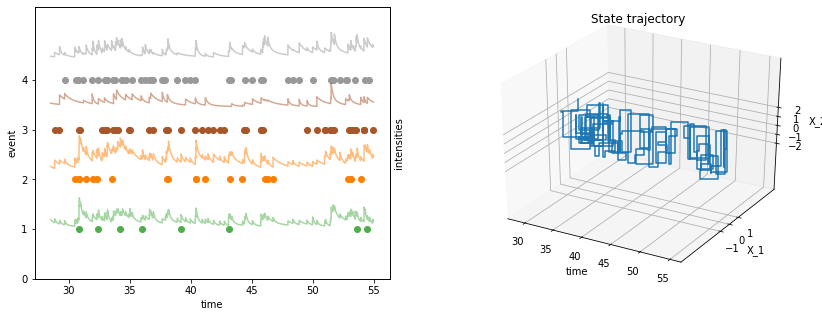

In [11]:
model.plot_events_and_states(t_0=28.5,t_1=55.0)

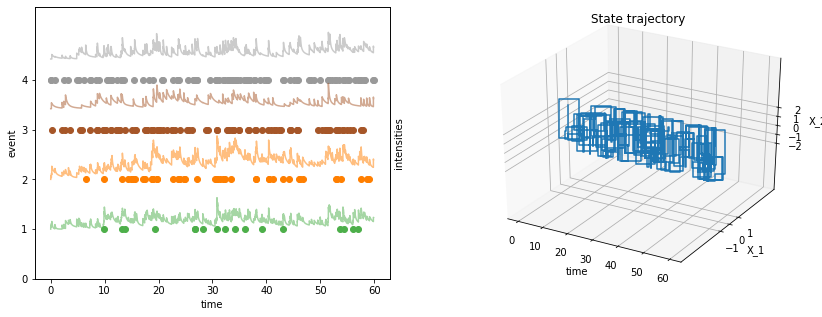

In [12]:
model.plot_events_and_states()

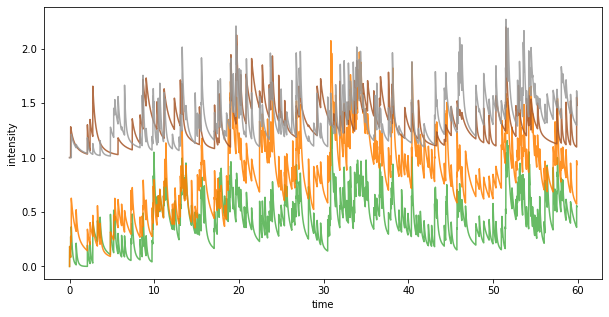

In [13]:
model.plot_intensities()

In [14]:
initial_condition_times=np.array(model.simulated_times,copy=True)
initial_condition_events=np.array(model.simulated_events,copy=True)
initial_condition_states=np.array(model.simulated_states,copy=True)
initial_condition_volumes=np.array(model.simulated_volume,copy=True)

In [15]:
initial_inventory=10
liquidator_base_rate=1.0
type_of_liquid = 'constant_intensity' #constant_intensity or with_the_market or against_the_market
liquidation_control_type='fraction_of_bid_side' # fraction_of_inventory or fraction_of_bid_side
liquidator_control=0.2
time_start=float(initial_condition_times[-1])
time_end=time_start+0.25*60*60

In [16]:
model.setup_liquidator(initial_inventory=initial_inventory,
                           time_start=time_start,
                           liquidator_base_rate=liquidator_base_rate,
                           type_of_liquid=type_of_liquid,
                           liquidator_control=liquidator_control)
initial_condition_events+=1

Hawkes parameters have been set
SDHawkes: asymmetry in transition_probabilities = 35.722662883389
Transition probabilities have been set
liquidator.initial_inventory: 10.0
liquidator.type_of_liquid: constant_intensity
liquidator.control_type: fraction_of_inventory
liquidator.control: 0.2
liquidator.start_time: 59.88982399045031


In [17]:
model.liquidator.print_info()

liquidator.initial_inventory: 10.0
liquidator.type_of_liquid: constant_intensity
liquidator.control_type: fraction_of_inventory
liquidator.control: 0.2
liquidator.start_time: 59.88982399045031


In [18]:
model.simulate_liquidation(
    time_end,
    initial_condition_events=initial_condition_events,
    initial_condition_states=initial_condition_states,
    initial_condition_times=initial_condition_times,
    initial_condition_volumes=initial_condition_volumes,
    verbose=True,
    report_history_of_intensities = False,
    store_results=True
)

Simulation is being performed on the following machine:
 posix.uname_result(sysname='Linux', nodename='elitebook', release='5.3.0-61-generic', version='#55~18.04.1-Ubuntu SMP Mon Jun 22 16:40:20 UTC 2020', machine='x86_64')
SDHawkes: simulate_liquidation. initial conditions have been acknowledged
simulate_liquidation. liquidator_control_type: fraction_of_inventory
  initial_invetory:10.0
   number_of_initial_events=242
initial state:1, initial event:4
simulate: labelled_times and count have been initialised.
 labelled_times.shape=(5,15,1000242), count.shape=(5,15)
simulate: intensities have been initialised.
  intensities at start: [1.         0.54986871 0.9357732  1.47977052 1.55955812]
  intensity_overall at start: 5.524970547328688
start of simulation
  time_start=59.88982399045031,  time at start =59.88982399045031
simulate_liquidation. At time 60.586307022634124, liquidator intervenes:
  previous state=[0 4], previous_volume=[0.09551343 0.3259689  0.0998301  0.47868756]
  quantity

simulate_liquidation. At time 99.94261228455925, liquidator intervenes:
  previous state=[1 2], previous_volume=[0.15118833 0.20186775 0.25995238 0.38699155]
  quantity_to_liquidate=0.2, to_subtract=[0.2 0. ], quantity_liquidated=0.2
  new_state=[1 2], new_volume=[0.15118833 0.00186775 0.25995238 0.38699155], new_tot_bid=0.38885929216186943.
simulate_liquidation. At time 101.25222470131162, liquidator intervenes:
  previous state=[2 3], previous_volume=[0.22962457 0.17424288 0.12131314 0.47481942]
  quantity_to_liquidate=0.2, to_subtract=[0.17424288 0.02575712], quantity_liquidated=0.2
  new_state=[0 2], new_volume=[0.22962457 0.         0.12131314 0.4490623 ], new_tot_bid=0.44906229759563043.
simulate_liquidation. At time 103.24910339137173, liquidator intervenes:
  previous state=[0 1], previous_volume=[0.24996226 0.31284675 0.3813403  0.0558507 ]
  quantity_to_liquidate=0.2, to_subtract=[0.2 0. ], quantity_liquidated=0.2
  new_state=[1 1], new_volume=[0.24996226 0.11284675 0.3813403

In [19]:
model.liquidator.print_info()

liquidator.initial_inventory: 10.0
liquidator.type_of_liquid: constant_intensity
liquidator.control_type: fraction_of_inventory
liquidator.control: 0.2
liquidator.start_time: 59.88982399045031
liquidator.termination_time: 107.89499922582765


In [20]:
model.make_start_liquid_origin_of_times(delete_negative_times=False)

SDHawkes: liquidator.start_time has been set as origin of times


In [21]:
model.create_impact_profile(delete_negative_times=False,
                            produce_weakly_defl_pp=False,
                            maxiter=10, num_init_guesses=1)

SDHawkes: liquidator.start_time has been set as origin of times

SDHawkes:  "liquidator.impact" has been initialised




In [22]:
model.liquidator.impact.store_bm_impact()

In [23]:
model.store_price_trajectory()

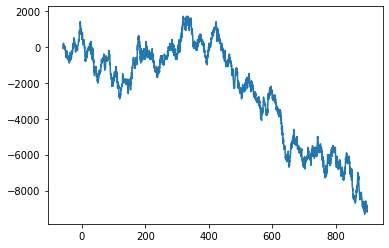

In [24]:
plt.plot(model.simulated_price[:,0], model.simulated_price[:,1])

In [25]:
model.store_history_of_intensities()

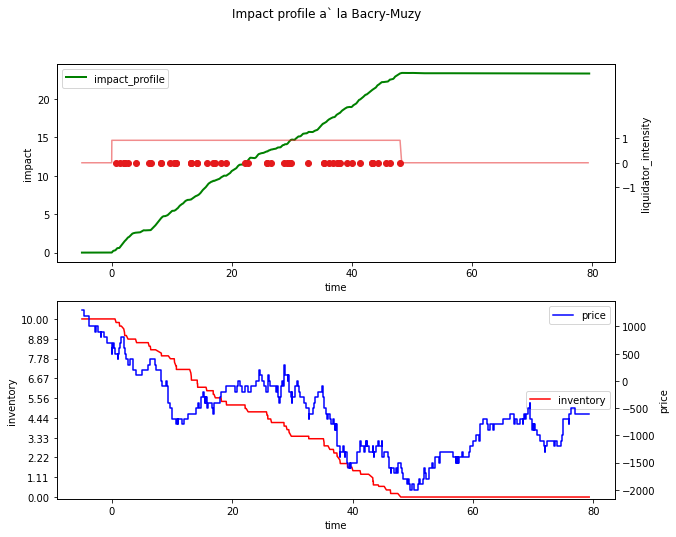

In [26]:
model.plot_bm_impact_profile(time_start=-5.0, time_end=80.0)

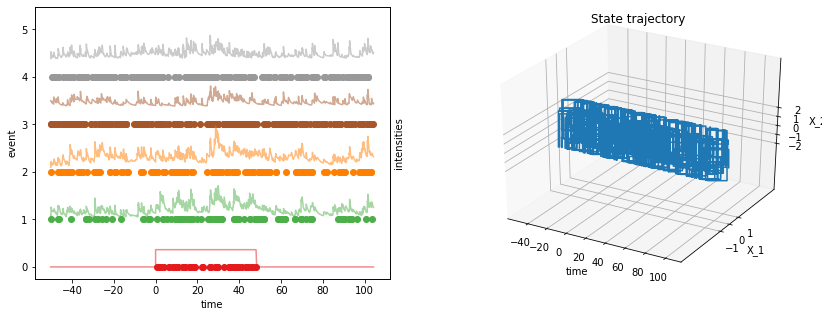

In [27]:
model.plot_events_and_states(t_0=-50.5,t_1=105.0, first_event_index=0)